In [1]:
pip list

Package                 Version
----------------------- -------------------
absl-py                 0.12.0
astunparse              1.6.3
backcall                0.2.0
cached-property         1.5.2
cachetools              4.2.2
certifi                 2021.5.30
chardet                 4.0.0
colorama                0.4.5
cycler                  0.11.0
dataclasses             0.8
decorator               5.1.1
entrypoints             0.4
flatbuffers             1.12
gast                    0.4.0
google-auth             1.30.1
google-auth-oauthlib    0.4.4
google-pasta            0.2.0
grpcio                  1.34.1
h5py                    3.1.0
idna                    2.10
importlib-metadata      4.5.0
ipykernel               5.5.6
ipython                 7.16.3
ipython-genutils        0.2.0
jedi                    0.17.2
joblib                  1.1.1
jupyter-client          7.1.2
jupyter-core            4.9.2
keras-nightly           2.5.0.dev2021032900
Keras-Preprocessing     1.1.2
kiwiso

In [1]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
matplotlib.rcParams['font.sans-serif']=['SimHei']
matplotlib.rcParams['axes.unicode_minus']=False
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,recall_score,accuracy_score

In [2]:
# 读入数据（注意异常捕获）
try:
    data=pd.read_csv('./telecom_users.csv')
except FileNotFoundError:
    print('没有找到该文件')

In [3]:
# 数据缺失值处理
data.TotalCharges=pd.to_numeric(data.TotalCharges,errors='coerce') # 转数值类型，并将缺失值替换为NaN
data.isnull().sum() # 查看数据缺失情况
data.dropna(inplace=True) # 由于缺失数据较少，直接drop该行即可
data=data.iloc[:,2:]

# 转分类变量
category_column = ['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod','Churn']
data[category_column] = data[category_column].astype('category')
data.dtypes

gender              category
SeniorCitizen       category
Partner             category
Dependents          category
tenure                 int64
PhoneService        category
MultipleLines       category
InternetService     category
OnlineSecurity      category
OnlineBackup        category
DeviceProtection    category
TechSupport         category
StreamingTV         category
StreamingMovies     category
Contract            category
PaperlessBilling    category
PaymentMethod       category
MonthlyCharges       float64
TotalCharges         float64
Churn               category
dtype: object

In [4]:
# 分类数据one-hot编码
data_dummies = pd.get_dummies(data[category_column],drop_first=True)
data.drop(columns=category_column,inplace=True)
data = data.join(data_dummies)
data.head()

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,72,24.10,1734.65,1,0,1,1,1,0,1,...,0,1,0,0,1,0,1,0,0,0
1,44,88.15,3973.20,0,0,0,0,1,0,0,...,1,0,0,0,0,1,1,0,0,0
2,38,74.95,2869.85,0,1,1,0,1,0,1,...,0,0,0,0,0,1,0,0,0,1
3,4,55.90,238.50,1,0,0,0,1,0,0,...,0,0,1,0,0,1,0,1,0,0
4,2,53.45,119.50,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [5]:
# 拆解成自变量和因变量
X = data.drop('Churn_Yes',axis = 1)
y = data['Churn_Yes']

# 1、探索性数据分析

## （1）单变量可视化

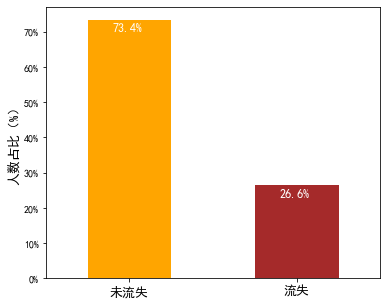

In [6]:
# 因变量分布：客户流失情况
plt.figure(figsize=(6,5))
churn_counts=y.value_counts()*100/len(y)
ax = churn_counts.plot(kind='bar',rot=0,color=['orange','brown'])
ax.yaxis.set_major_formatter(mtick.PercentFormatter()) # 按百分比显示
plt.ylabel('人数占比（%）',fontsize=13)
plt.xticks([0,1],['未流失','流失'],fontsize=13)
totals=[]
for i in ax.patches:
    totals.append(i.get_width())
total=sum(totals)
for i in ax.patches:
    ax.text(i.get_x()+.15,i.get_height()-3.5,str(round((i.get_height()/total),1))+'%',fontsize=12,color='white',weight='bold')
plt.show()

样本中，未流失客户（Y=0）的数量远远高于流失客户（Y=1）的数量，数据不平衡，若不调整容易影响模型的构建。

## （2）多变量可视化

<AxesSubplot:>

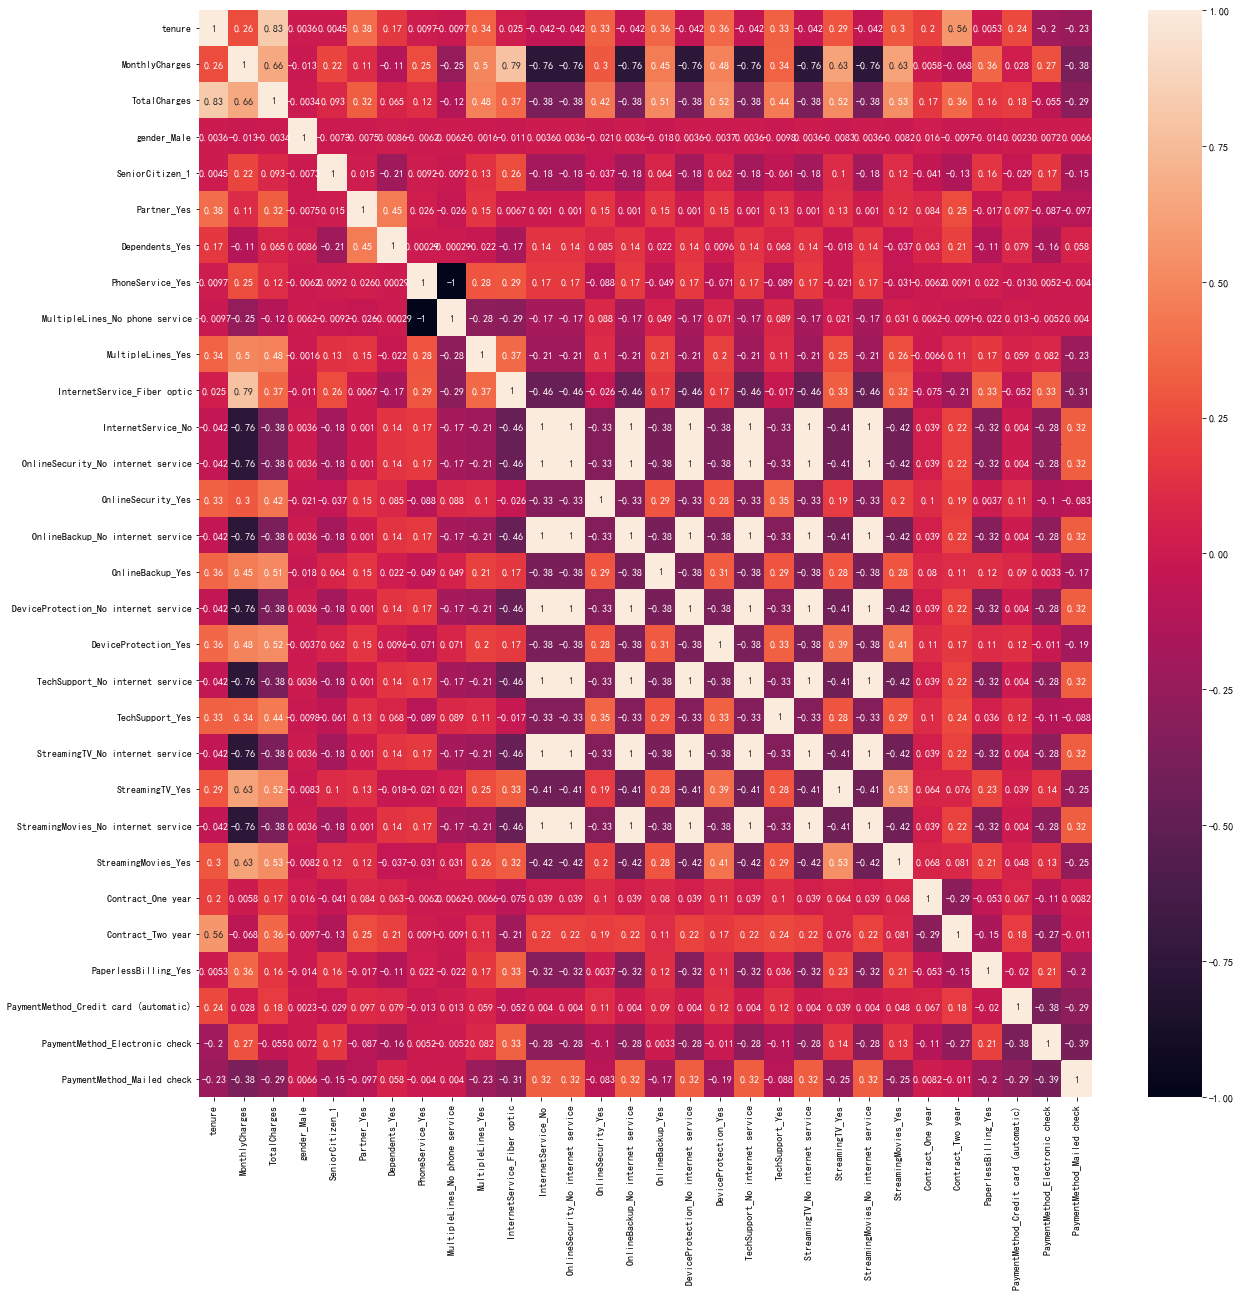

In [8]:
# 自变量相关性
plt.figure(figsize=(20,20))
sns.heatmap(X.corr(), annot=True)

存在大量特征相关系数为1，这些都是需要进行剔除的。

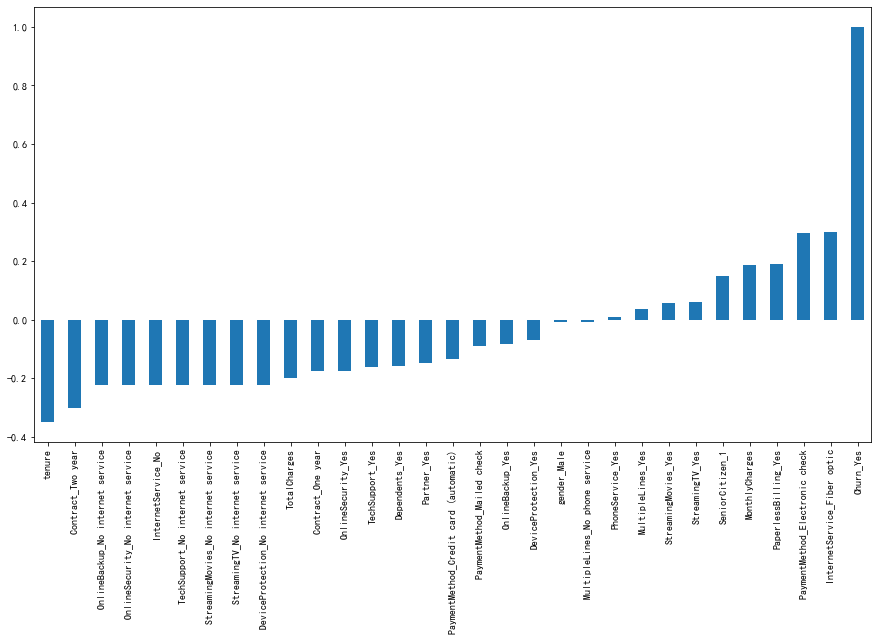

In [9]:
# 自变量与因变量的相关性：由负相关变为正相关（相关性由高到低再到高）
plt.figure(figsize=(15,8))
data.corr()['Churn_Yes'].sort_values(ascending=True).plot(kind='bar')
plt.show()

# 2、预处理：数据重采样

In [7]:
# 定义模型评价类：给定模型、数据，计算准确度、召回率
class model_evaluation():
    def __init__(self, model_list, X, y, split):
        self.model_list = model_list
        self.X = X
        self.y = y
        
        # 划分训练集与测试集
        if(split==True):
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X,y,test_size = 0.30, random_state = 40)
        else:
            self.X_train, self.X_test, self.y_train, self.y_test = X, X, y, y
        
        # 对每个模型进行训练
        for model in model_list:
            model.fit(self.X_train, self.y_train)
    
    def get_score(self,score_type): # 评价指标：准确度、召回率、混淆矩阵
        train_score = []
        test_score = []
        if(score_type=='accuracy'):
            for model in self.model_list:
                train_score.append(accuracy_score(self.y_train,model.predict(self.X_train)))
                test_score.append(accuracy_score(self.y_test,model.predict(self.X_test)))
        elif(score_type=='recall'):
            for model in self.model_list:
                train_score.append(recall_score(self.y_train,model.predict(self.X_train)))
                test_score.append(recall_score(self.y_test,model.predict(self.X_test)))
        elif(score_type=='cfmatrix'):
            for model in self.model_list:
                train_score.append(confusion_matrix(self.y_train,model.predict(self.X_train)))
                test_score.append(confusion_matrix(self.y_test,model.predict(self.X_test)))
        else:
            raise ValueError('请选择准确度、召回率或混淆矩阵作为评价指标') # 异常处理
        
        return train_score,test_score

In [8]:
# 自定义函数：数据重采样
def balance(dataset):
    reshuffle=dataset.sample(frac=1,random_state=0)
    Churn_yes=reshuffle.iloc[(reshuffle['Churn_Yes']==1).tolist()]
    Churn_no=reshuffle.iloc[(reshuffle['Churn_Yes']==0).tolist()].sample(n=len(Churn_yes),random_state=0)
    total=pd.concat([Churn_yes,Churn_no])
    return total

# 自定义函数：混淆矩阵可视化
def plot_confusion_matrix(confusion_mat):
    confusion_mat = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis]  # 归一化
    plt.imshow(confusion_mat,interpolation='nearest',cmap=plt.get_cmap('Blues'))
    #plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks=np.arange(2)
    plt.xticks(tick_marks,tick_marks)
    plt.yticks(tick_marks,tick_marks)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    for i in [0,1]:
        for j in [0,1]:
            if int(confusion_mat[i][j]*100 + 0.5) > 0:
                plt.text(j,i,format(int(confusion_mat[i][j] * 100 + 0.5), 'd') + '%',
                         ha = 'center',va = 'center',
                         color = 'white' if confusion_mat[i][j] > 0.5 else 'black')

In [12]:
#### 比较重采样的效果 ####
# 模型：
model_list = ['原始模型','重设类间权重','重调阈值','重采样']
model1 = LogisticRegressionCV(penalty = 'l2',cv = 5,random_state = 0,max_iter=5000) # 原始模型
model2 = LogisticRegressionCV(penalty = 'l2',cv = 5,random_state = 0,class_weight = 'balanced', max_iter=5000) # 重设类间权值

# 数据：重采样后的数据
data_balance = balance(data)
X_balance = data_balance.drop('Churn_Yes',axis = 1)
y_balance = data_balance['Churn_Yes']

# 方法：LR+原始数据、LR+重设类间权重、LR+重调阈值、LR+重采样数据
# 原始模型、重设类间权重
evaluator = model_evaluation([model1, model2], X, y, split=False)
acc = evaluator.get_score('accuracy')[0]
rec = evaluator.get_score('recall')[0]
cfmatrix = evaluator.get_score('cfmatrix')[0]

#重设阈值(原理同重设权重，结果同上，不予考虑)
pred_proba = model1.fit(X,y).predict_proba(X)[:,1]
thres = 1587/5976
yhat = pred_proba > thres
acc.append(accuracy_score(y,yhat))
rec.append(recall_score(y,yhat))
cfmatrix.append(confusion_matrix(y,yhat))

# 重采样
yhat = model1.fit(X_balance,y_balance).predict(X_balance)
acc.append(accuracy_score(y_balance,yhat))
rec.append(recall_score(y_balance,yhat))
cfmatrix.append(confusion_matrix(y_balance,yhat))

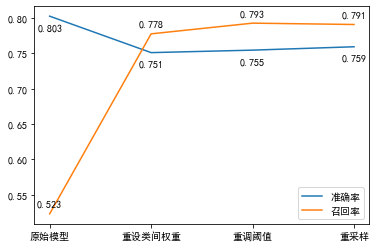

In [13]:
# 可视化：准确度、召回率比较
x = range(1,5,1)
plt.plot(x,acc,label="准确率")
plt.plot(x,rec,label="召回率")
plt.xticks(x,model_list)
plt.legend(loc='best')
for a, b in zip(x, acc):
    plt.text(a, b-0.02, b.round(3), ha='center')
for a, b in zip(x, rec):
    plt.text(a, b+0.01, b.round(3), ha='center')
plt.show()

Text(0.5, 1.0, '重设类间权重')

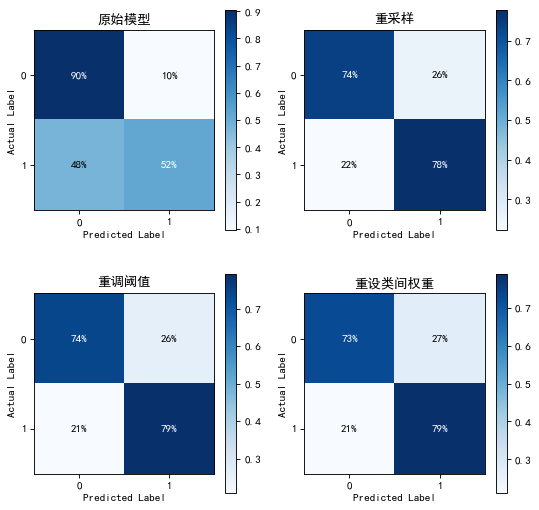

In [14]:
# 可视化：混淆矩阵
plt.figure(figsize=(8,8), dpi=80)
plt.figure(1)
ax1 = plt.subplot(221)
plot_confusion_matrix(cfmatrix[0])
plt.title('原始模型')
ax2 = plt.subplot(222)
plot_confusion_matrix(cfmatrix[1])
plt.title('重采样')
ax3 = plt.subplot(223)
plot_confusion_matrix(cfmatrix[2])
plt.title('重调阈值')
ax4 = plt.subplot(224)
plot_confusion_matrix(cfmatrix[3])
plt.title('重设类间权重')

#  3、初筛模型：比较不同预测模型拟合度、过拟合度（用重采样后的结果）

In [10]:
# 先依据前文可视化的相关系数图，删除相关系数高的特征
delete_feature = ['OnlineSecurity_No internet service','OnlineBackup_No internet service','DeviceProtection_No internet service','TechSupport_No internet service','StreamingTV_No internet service','StreamingMovies_No internet service']
data.drop(columns=delete_feature,inplace=True)
X_balance.drop(columns=delete_feature,inplace=True)

In [50]:
# 模型准备
model_list = [DecisionTreeClassifier(),
              RandomForestClassifier(),
              KNeighborsClassifier(),
              SVC(),
              MLPClassifier(),
              LogisticRegression(max_iter=3000),
              AdaBoostClassifier(),
              XGBClassifier(tree_method='gpu_hist',enable_categorical=True)]
model_label = ['DecisionTree','RF','KNN','SVM','NN','LR','AdaBoost','XGBoost']

# 计算各模型精度
evaluator = model_evaluation(model_list, X_balance, y_balance, split=True)
train_acc, test_acc = evaluator.get_score('accuracy')
sub_acc = [x-y for x,y in zip(train_acc,test_acc)]

[02:07:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


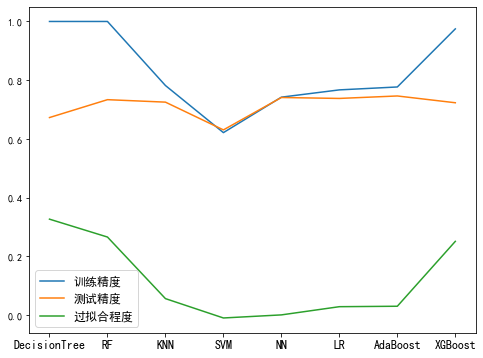

In [51]:
# 可视化：不同模型的拟合、过拟合程度
x = range(1,len(model_list)+1,1)
plt.figure(figsize=(8,6))
plt.plot(x,train_acc,label="训练精度")
plt.plot(x,test_acc,label="测试精度")
plt.plot(x,sub_acc,label="过拟合程度")
plt.xticks(x,model_label,fontsize=12)
plt.legend(loc='best',fontsize=12)
plt.show()

# 4、特征选择

In [15]:
# 自定义函数，获得训练精度、测试精度、过拟合度（二者之差）
def get_acc(X,y,train_acc,test_acc,sub_acc):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.30, random_state = 40)
    newModel = RandomForestClassifier()
    newModel.fit(X_train, y_train)
    acc1 = accuracy_score(y_train,newModel.predict(X_train))
    acc2 = accuracy_score(y_test,newModel.predict(X_test))
    train_acc.append(acc1)
    test_acc.append(acc2)
    sub_acc.append(acc1-acc2)

In [21]:
train_acc = []
test_acc = []
sub_acc = []

#### 降维方法的比较 ####
# PCA降维
from sklearn.decomposition import PCA
max_degree = X_balance.shape[1]
for i in range(1,max_degree+1,1):
    newX = PCA(n_components=i).fit_transform(X_balance)
    get_acc(newX,y_balance,train_acc,test_acc,sub_acc)
    
# 逻辑回归、随机森林降维
from sklearn.feature_selection import RFE
estimators=[LogisticRegression(max_iter=3000),
            RandomForestClassifier(n_estimators = 100,bootstrap = True,max_features = 'sqrt')]
for estimator in estimators:
    for i in range(1,max_degree+1,1):
        selector=RFE(estimator=estimator,n_features_to_select=i)
        selector.fit(X_balance,y_balance)
        X_select = selector.transform(X_balance)
        X_select = pd.DataFrame(X_select)
        get_acc(X_select,y_balance,train_acc,test_acc,sub_acc)

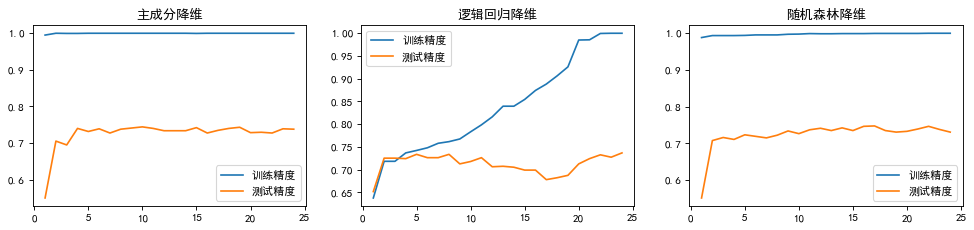

In [23]:
# 可视化：绘制精度图（随维度变化）
plt.figure(figsize=(15,3), dpi=80)
x = range(1,max_degree+1,1)  
plt.figure(1)
ax1 = plt.subplot(131)   
plt.title('主成分降维')
plt.plot(x,train_acc[0:max_degree],label="训练精度")
plt.plot(x,test_acc[0:max_degree],label="测试精度")
plt.legend(loc='best')
ax2 = plt.subplot(132)
plt.title('逻辑回归降维')
plt.plot(x,train_acc[max_degree:max_degree*2],label="训练精度")
plt.plot(x,test_acc[max_degree:max_degree*2],label="测试精度")
plt.legend(loc='best')
ax3 = plt.subplot(133)
plt.title('随机森林降维')
plt.plot(x,train_acc[max_degree*2:max_degree*3],label="训练精度")
plt.plot(x,test_acc[max_degree*2:max_degree*3],label="测试精度")
plt.legend(loc='best')

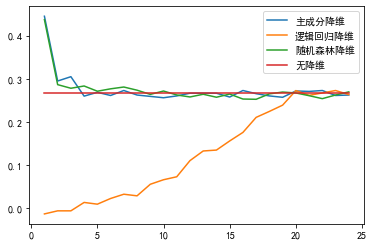

In [25]:
# 可视化：绘制过拟合度图（随维度变化）
plt.plot(x,sub_acc[0:max_degree],label="主成分降维")
plt.plot(x,sub_acc[max_degree:max_degree*2],label="逻辑回归降维")
plt.plot(x,sub_acc[max_degree*2:max_degree*3],label="随机森林降维")
plt.plot(x,[0.266]*max_degree,label="无降维")
plt.legend(loc='best')
plt.show()

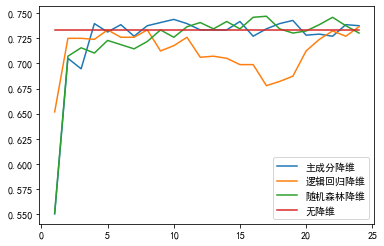

In [26]:
# 可视化：绘制测试集精度对比图
plt.plot(x,test_acc[0:max_degree],label="主成分降维")
plt.plot(x,test_acc[max_degree:max_degree*2],label="逻辑回归降维")
plt.plot(x,test_acc[max_degree*2:max_degree*3],label="随机森林降维")
plt.plot(x,[0.733]*max_degree,label="无降维")
plt.legend(loc='best')
plt.show()

通过综合比较不同降维方法对过拟合度下降程度、模型测试精度的大小，我们确定使用逻辑回归降维，选择维度为5~10进行测试。
值得注意的是，在这里我们使用的验证模型是随机森林，所以这里得到的测试精度是针对随机森林模型得到的，无法保证在其他模型下也能得到如此的测试误差，所以在选择降维方法时，我们的重点在于过拟合度而非测试精度。 

In [27]:
#逻辑回归降维，选择维度为10
estimator = LogisticRegression(max_iter=3000)
selector=RFE(estimator=estimator,n_features_to_select=1)
selector.fit(X_balance,y_balance)
print("变量重要性排名 %s"%selector.ranking_)

index = list(selector.ranking_[:10]-1)
X_select = X_balance.iloc[:,index]

变量重要性排名 [20 22 24 19 17 11 21 14  8 18  3  4  5  9 13  7 16 10  2  1 12 15  6 23]


In [14]:
#随机森林降维，选择维度15
estimator = RandomForestClassifier(n_estimators = 100,bootstrap = True,max_features = 'sqrt')
selector=RFE(estimator=estimator,n_features_to_select=1)
selector.fit(X_balance,y_balance)
print("变量重要性排名 %s"%selector.ranking_)

index_tree = list(selector.ranking_[:15]-1)
X_select_tree = X_balance.iloc[:,index_tree]

变量重要性排名 [ 3  2  1  8 18 12 14 24 23 16  5 10 11 15 19 13 20 17  7  4  9 21  6 22]


# 5、模型构建：神经网络

### （1）第一种方法

In [75]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU, PReLU, ELU
from keras.layers import Dropout

classifier = Sequential()
classifier.add(Dense(6, kernel_initializer = 'he_uniform',activation='relu',input_dim = 10)) # 使用了特征选择后的变量，所以这里输入维度为10
classifier.add(Dropout(0.1))
classifier.add(Dense(6, kernel_initializer = 'he_uniform',activation='relu'))
classifier.add(Dropout(0.1))
classifier.add(Dense(1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))
classifier.compile(optimizer='Adamax', loss='binary_crossentropy', metrics=['accuracy'])

In [78]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 66        
_________________________________________________________________
dropout (Dropout)            (None, 6)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 42        
_________________________________________________________________
dropout_1 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 7         
Total params: 115
Trainable params: 115
Non-trainable params: 0
_________________________________________________________________


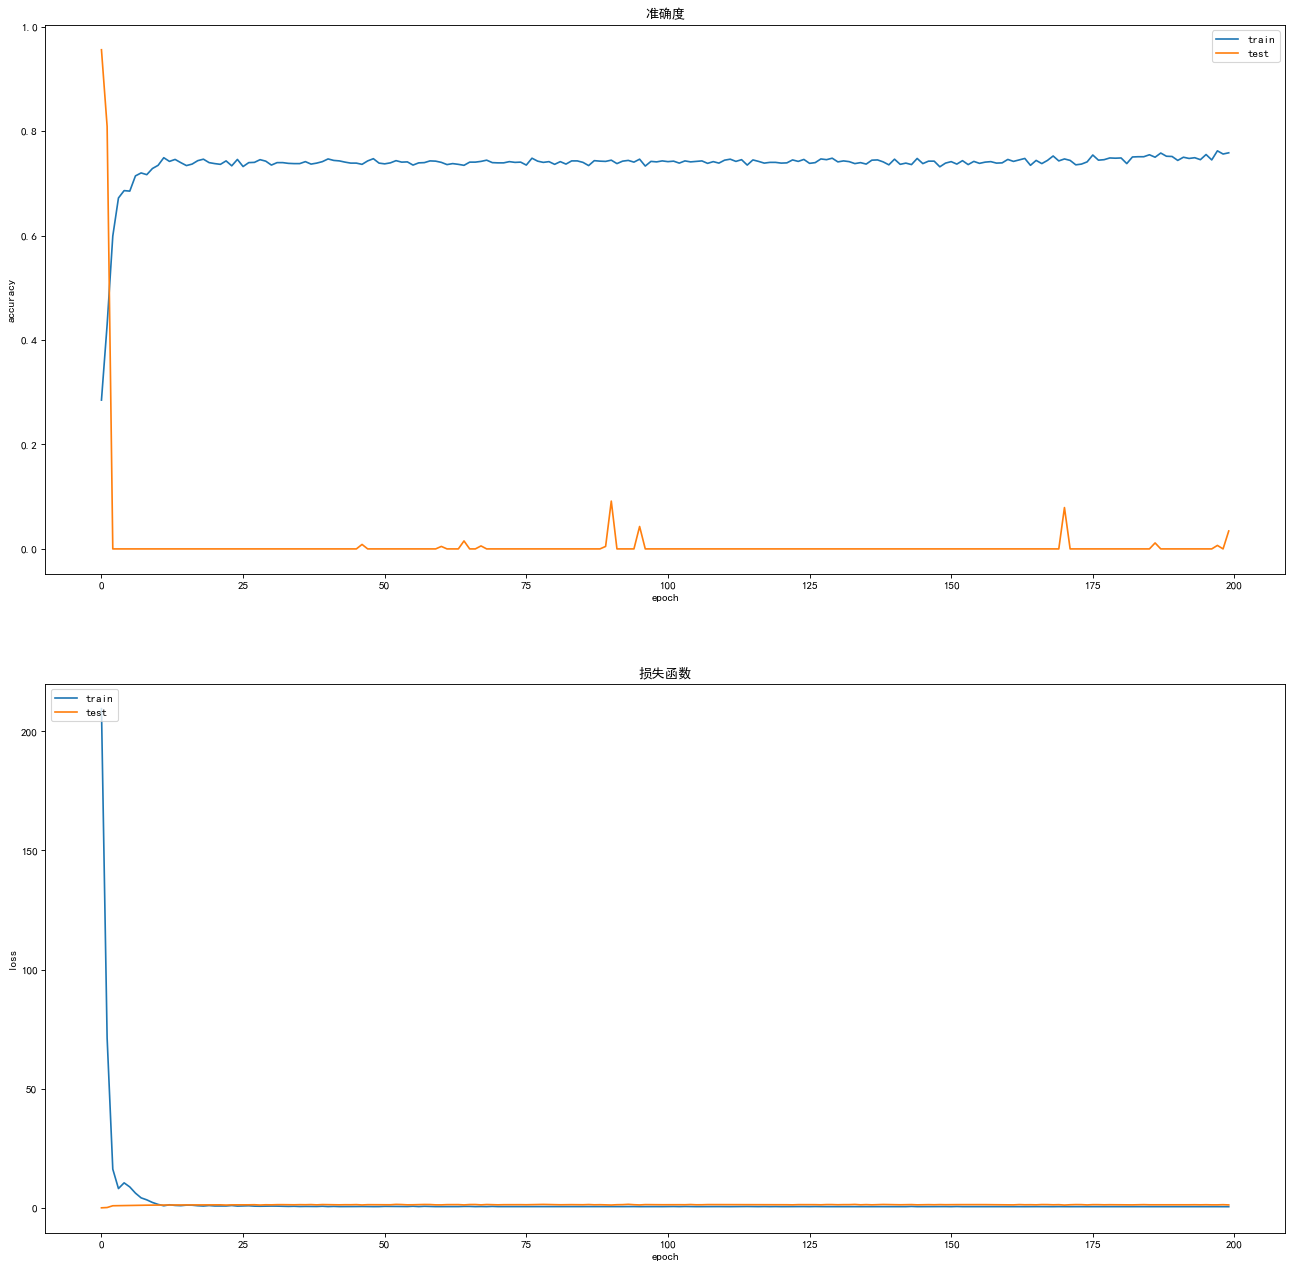

In [57]:
#利用keras构建神经网络
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU, PReLU, ELU
from keras.layers import Dropout

classifier = Sequential()
classifier.add(Dense(6, kernel_initializer = 'he_uniform',activation='relu',input_dim = 10)) # 使用了特征选择后的变量，所以这里输入维度为10
classifier.add(Dropout(0.1))
classifier.add(Dense(6, kernel_initializer = 'he_uniform',activation='relu'))
classifier.add(Dropout(0.1))
classifier.add(Dense(1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))
classifier.compile(optimizer='Adamax', loss='binary_crossentropy', metrics=['accuracy'])

def NN_plot(n,sizex,sizey):
    model_history = classifier.fit(X_select, y_balance, validation_split=0.33, batch_size = 10, epochs = n,verbose=0)
    plt.figure(figsize=(sizex,sizey), dpi=80) 
    plt.figure(1)
    ax1 = plt.subplot(211)   
    plt.plot(model_history.history['accuracy'][0:n],label="train")
    plt.plot(model_history.history['val_accuracy'][0:n],label="test")
    plt.title('准确度')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='best')
    ax2 = plt.subplot(212)
    plt.plot(model_history.history['loss'][0:n],label="train")
    plt.plot(model_history.history['val_loss'][0:n],label="test")
    plt.title('损失函数')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    plt.show()
    
#训练200轮
NN_plot(200,20,20)

### （2）第二种方法 

In [16]:
# 使用sklearn中的MLP分类器构建神经网络，随机搜索参数
from sklearn.neural_network import MLPClassifier
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
        'solver':['lbfgs','adam','sgd'],
        'activation':['logistic','tanh','relu'],
        'hidden_layer_sizes':(sp_randint.rvs(1,100,1),sp_randint.rvs(1,100,1))
        }
mlp = MLPClassifier(alpha=1e-5,random_state=1)
grid = RandomizedSearchCV(mlp,param_dist,cv = 3,scoring = 'accuracy',n_iter=300,n_jobs = -1)

In [59]:
# 未降维数据
grid.fit(X_balance,y_balance)
best_estimator = grid.best_estimator_
print("最优模型参数：",best_estimator)

X_train, X_test, y_train, y_test = train_test_split(X_balance,y_balance,test_size = 0.30, random_state = 40)
best_estimator.fit(X_train,y_train)
print("训练精度：",accuracy_score(y_train,best_estimator.predict(X_train)))
print("测试精度：",accuracy_score(y_test,best_estimator.predict(X_test)))
print("训练召回率：",recall_score(y_train,best_estimator.predict(X_train)))
print("测试召回率：",recall_score(y_test,best_estimator.predict(X_test)))

最优模型参数： MLPClassifier(activation='logistic', alpha=1e-05, hidden_layer_sizes=34,
              random_state=1)
训练精度： 0.7514633048176497
测试精度： 0.7397691500524659
训练召回率： 0.7922437673130194
测试召回率： 0.7857142857142857


In [60]:
#自定义函数：输入数据，用神经网络训练数据，返回精度和召回率
def MLP(X,y,up,down):
    train_acc = []
    test_acc = []
    train_rec = []
    test_rec = []
    for i in range(up,down,1):
        XNew = X.iloc[:,0:i]
        grid.fit(XNew,y)
        best_estimator = grid.best_estimator_
        print(best_estimator)
        
        X_train, X_test, y_train, y_test = train_test_split(XNew,y,test_size = 0.30, random_state = 40)
        best_estimator.fit(X_train,y_train)
        
        train_acc.append(accuracy_score(y_train,best_estimator.predict(X_train)))
        test_acc.append(accuracy_score(y_test,best_estimator.predict(X_test)))
        train_rec.append(recall_score(y_train,best_estimator.predict(X_train)))
        test_rec.append(recall_score(y_test,best_estimator.predict(X_test)))
        
    x = range(up,down,1)
    plt.figure(figsize=(10,3), dpi=80)
    plt.figure(1)
    ax1 = plt.subplot(121)   
    plt.title('准确率')
    plt.plot(x,train_acc,label="train")
    plt.plot(x,test_acc,label="test")
    plt.plot(x,[0.7352]*6,linestyle='-.',label="train（无降维）")
    plt.plot(x,[0.7345]*6,linestyle='-.',label="test（无降维）")
    plt.legend(loc='best')   
    ax2 = plt.subplot(122)
    plt.title('召回率')
    plt.plot(x,test_rec,label="train")
    plt.plot(x,train_rec,label="test")
    plt.plot(x,[0.8624]*6,linestyle='-.',label="train（无降维）")
    plt.plot(x,[0.8532]*6,linestyle='-.',label="test（无降维）")
    plt.legend(loc='best')    

MLPClassifier(alpha=1e-05, hidden_layer_sizes=34, random_state=1,
              solver='lbfgs')
MLPClassifier(alpha=1e-05, hidden_layer_sizes=57, random_state=1,
              solver='lbfgs')
MLPClassifier(alpha=1e-05, hidden_layer_sizes=34, random_state=1,
              solver='lbfgs')
MLPClassifier(alpha=1e-05, hidden_layer_sizes=34, random_state=1,
              solver='lbfgs')
MLPClassifier(alpha=1e-05, hidden_layer_sizes=57, random_state=1,
              solver='lbfgs')
MLPClassifier(alpha=1e-05, hidden_layer_sizes=57, random_state=1,
              solver='lbfgs')


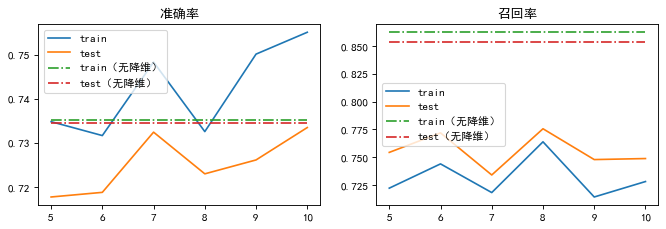

In [61]:
# 逻辑回归降维
MLP(X_select,y_balance,5,11)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=57, random_state=1,
              solver='lbfgs')
MLPClassifier(alpha=1e-05, hidden_layer_sizes=57, random_state=1,
              solver='lbfgs')
MLPClassifier(alpha=1e-05, hidden_layer_sizes=34, random_state=1,
              solver='lbfgs')
MLPClassifier(alpha=1e-05, hidden_layer_sizes=57, random_state=1,
              solver='lbfgs')
MLPClassifier(activation='logistic', alpha=1e-05, hidden_layer_sizes=57,
              random_state=1)
MLPClassifier(alpha=1e-05, hidden_layer_sizes=57, random_state=1,
              solver='lbfgs')


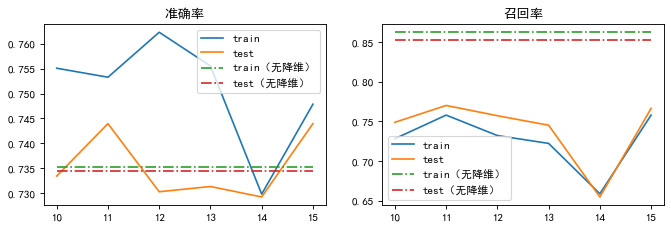

In [62]:
# 随机森林降维
MLP(X_select_tree,y_balance,10,16)

# 6、模型构建：神经网络集成

### （1）第一种方法 

In [64]:
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
base = MLPClassifier(alpha=1e-5,random_state=1)
kfold = model_selection.KFold(n_splits=3,shuffle=True,random_state=7)
model = BaggingClassifier(base_estimator=base,n_estimators=10,random_state=7)
results = model_selection.cross_val_score(model,X_select,y_balance,cv=kfold)
print(results.mean())

0.7435412728418399


### （2）第二种方法

In [66]:
#自定义函数：有放回抽样，构造不同的数据集
def subsample(X, y):
    sample1 = X.loc[y==1,:].sample(n=777,replace=True)
    sample2 = X.loc[y==0,:].sample(n=777,replace=True)
    newX = sample1.append(sample2)
    newy = y[newX.index]
    return newX,newy

#自定义函数：用所有已训练的模型预测，将预测值横向拼接
def result(model,X):
    yhat = model[0].predict(X)
    for i in range(1,len(model),1):
        yhat = np.vstack((yhat,model[i].predict(X)))
    return yhat.T

# 集成模型类：输入基模型、最大的集成模型个数、数据
class bagging():
    def __init__(self, base_model, max_model_number, X, y):
        self.max_model_number = max_model_number
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X,y,test_size = 0.30, random_state = 40)
    
        self.models = []
        for i in range(max_model_number):
            sub_X,sub_y = subsample(self.X_train, self.y_train)
            if(base_model==1):
                mlp = MLPClassifier().fit(sub_X,sub_y)
                self.models.append(mlp)
            elif(base_model==2):
                mlp = MLPClassifier(alpha=1e-05, hidden_layer_sizes=57, random_state=1,solver='lbfgs').fit(sub_X,sub_y)
                self.models.append(mlp)
            else: 
                raise ValueError('请选择合适的基模型')
    
    def get_accuracy(self): # 评价指标：准确度
        y_hat_train = result(self.models,self.X_train)
        y_hat_test = result(self.models,self.X_test)
        
        train_acc = []
        test_acc = []
        train_rec = []
        test_rec = []
        for i in range(1,self.max_model_number+1,1):
            y_hat_tmp = np.round(y_hat_train[:,0:i].mean(axis = 1)).astype(np.int64)
            train_acc.append(accuracy_score(self.y_train,y_hat_tmp))
            train_rec.append(recall_score(self.y_train,y_hat_tmp))

            y_hat_tmp = np.round(y_hat_test[:,0:i].mean(axis = 1)).astype(np.int64)
            test_acc.append(accuracy_score(self.y_test,y_hat_tmp))
            test_rec.append(recall_score(self.y_test,y_hat_tmp))
            
        return train_acc,test_acc,train_rec,test_rec

In [67]:
# 比较不同降维方式下，同一模型的精度
train_acc_1,test_acc_1,train_rec_1,test_rec_1 = bagging(1,50,X_balance,y_balance).get_accuracy()
train_acc_2,test_acc_2,train_rec_2,test_rec_2 = bagging(2,50,X_select,y_balance).get_accuracy()
train_acc_3,test_acc_3,train_rec_3,test_rec_3 = bagging(2,50,X_select_tree,y_balance).get_accuracy()
train_score = [train_acc_1,train_acc_2,train_acc_3,train_rec_1,train_rec_2,train_rec_3]
test_score = [test_acc_1,test_acc_2,test_acc_3,test_rec_1,test_rec_2,test_rec_3]

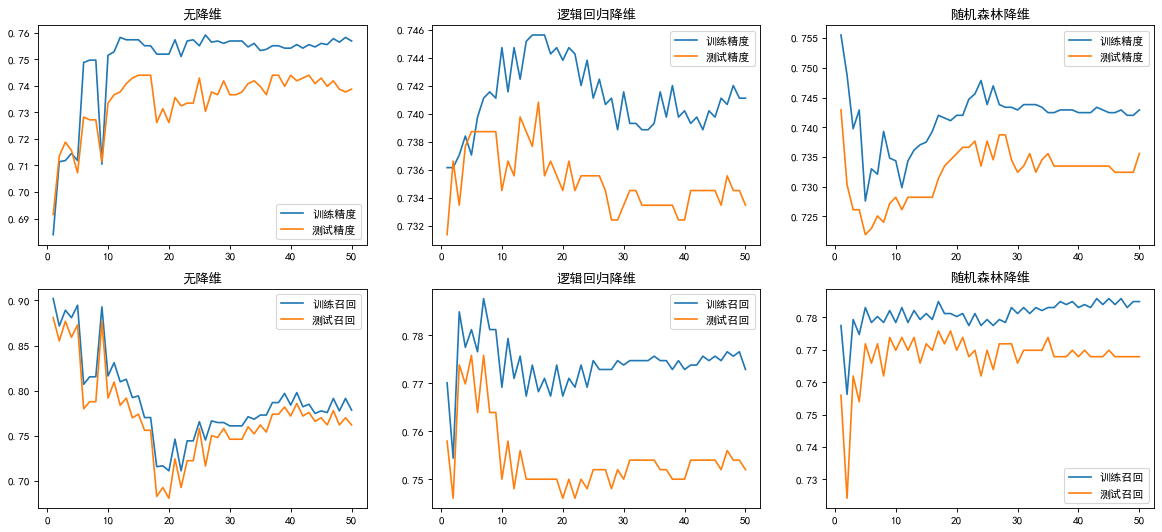

In [70]:
x = range(1,51,1)
labels = ['训练精度','训练召回','测试精度','测试召回']
titles = ['无降维','逻辑回归降维','随机森林降维']
fig,ax = plt.subplots(2,3,figsize=(18,8), dpi=80)
for i in range(6):
    ax[i//3][i%3].plot(x,train_score[i],label=labels[i//3])
    ax[i//3][i%3].plot(x,test_score[i],label=labels[i//3+2])
    ax[i//3][i%3].set_title(titles[i%3])
    ax[i//3][i%3].legend(loc='best')

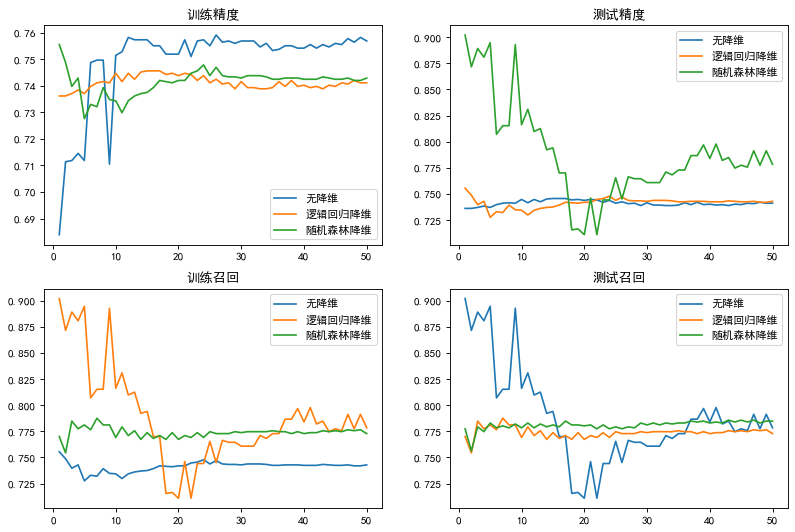

In [73]:
fig,ax = plt.subplots(2,2,figsize=(12,8), dpi=80)
x = range(1,51,1)
for i in range(2):
    ax[i//2][i%2].plot(x,train_score[i+0],label="无降维")
    ax[i//2][i%2].plot(x,train_score[i+1],label="逻辑回归降维")
    ax[i//2][i%2].plot(x,train_score[i+2],label="随机森林降维")
    ax[i//2][i%2].set_title(labels[i*2])
    ax[i//2][i%2].legend(loc='best')
for i in range(2,4):
    ax[i//2][i%2].plot(x,train_score[i+0],label="无降维")
    ax[i//2][i%2].plot(x,train_score[i+1],label="逻辑回归降维")
    ax[i//2][i%2].plot(x,train_score[i+2],label="随机森林降维")
    ax[i//2][i%2].set_title(labels[i*2-3])
    ax[i//2][i%2].legend(loc='best')